In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_context
import seaborn as sns
from tqdm import tqdm

from scipy.spatial import Voronoi, voronoi_plot_2d

from joblib import Parallel, delayed
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load data
data = pd.read_csv('MERFISH_all_neurons_with_clusters.csv',)

In [3]:
data

,names,center_x,center_y,cluster_no,cell_type
0,2997859600113100167-mPFC_NF3_r1-mPFC,12327.278045,251.863716,20,N_Npy
1,2997859600113200028-mPFC_NF3_r1-mPFC,12327.414009,256.825433,20,N_Npy
2,2997859600114100049-mPFC_NF3_r1-mPFC,12423.789059,251.808271,17,N_Vip
3,2997859600114100072-mPFC_NF3_r1-mPFC,12419.459898,249.237627,17,N_Vip
4,2997859600155100225-mPFC_NF3_r1-mPFC,12067.190688,368.017769,13,N_Sst
...,...,...,...,...,...
1245620,2786071603898100040-BLA_FR15-BLA,4523.666210,8951.213162,20,N_Npy
1245621,2786071603898100046-BLA_FR15-BLA,4522.390352,8958.848743,20,N_Npy
1245622,2786071603946200001-BLA_FR15-BLA,3440.803372,9071.063728,20,N_Npy
1245623,2786071603948100058-BLA_FR15-BLA,3785.804506,9090.659302,20,N_Npy


In [4]:
fov = [None] * data.shape[0]
for i in range(data.shape[0]):
    fov[i] = data['names'][i].split('-')[1] + '-' + data['names'][i].split('-')[2]
data['fov'] = fov

In [5]:
data_fov = data.groupby('fov')
fovs = list(data_fov.groups.keys())
single_fov = data_fov.get_group(fovs[0])

<Axes: xlabel='center_x', ylabel='center_y'>

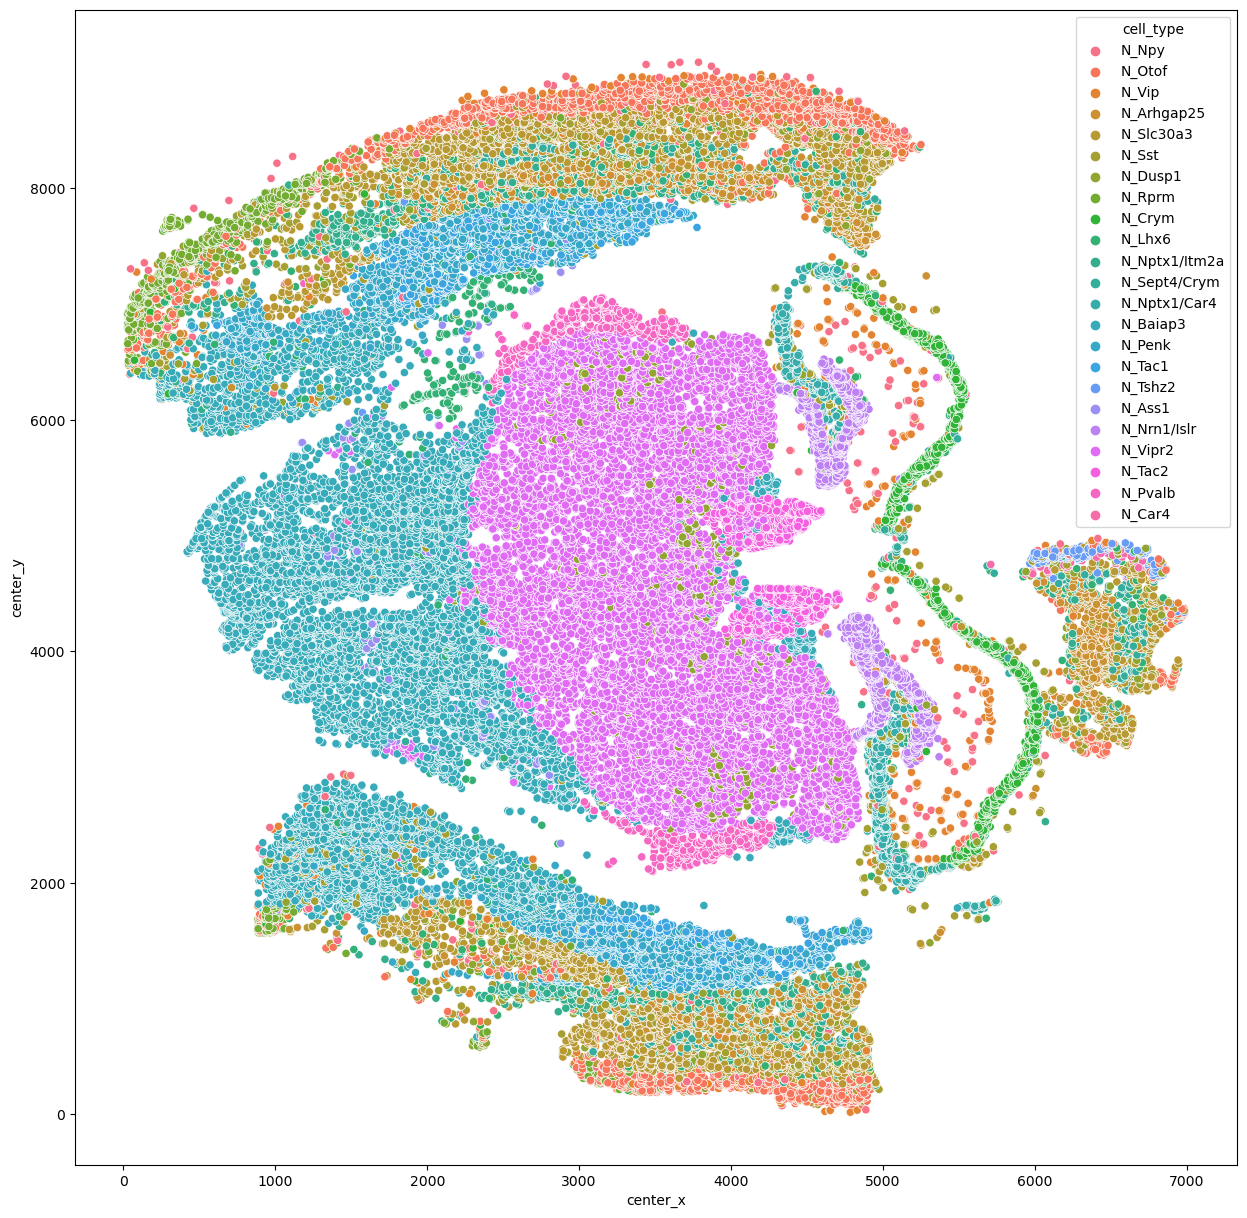

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.scatterplot(x='center_x', y='center_y', data=single_fov, hue='cell_type', ax=ax)

In [7]:
vor = Voronoi(single_fov[['center_x', 'center_y']].values)

In [8]:
len(vor.ridge_vertices)

170672

In [9]:
single_fov.reset_index(inplace=True)

In [10]:
# find unique pairs of cell types
cell_types = single_fov['cell_type'].unique()
pairs = []
for i in range(len(cell_types)):
    for j in range(i, len(cell_types)):
        pairs.append((cell_types[i], cell_types[j]))

In [11]:
def count_ridges(vor, cell_types):
    ridge_count = {}
    for item in pairs:
        ridge_count[item[0]+'-'+item[1]] = 0
    for i,ridge in enumerate(vor.ridge_points):
        if -1 in ridge:
            continue
        cell1 = cell_types[ridge[0]]
        cell2 = cell_types[ridge[1]]
        if cell1 == cell2:
            continue
        if cell1+'-'+cell2 in ridge_count:
            ridge_count[cell1+'-'+cell2] = ridge_count[cell1+'-'+cell2] + 1
        elif cell2+'-'+cell1 in ridge_count:
            ridge_count[cell2+'-'+cell1] = ridge_count[cell2+'-'+cell1] + 1
        else:
            ridge_count[cell1+'-'+cell2] = 1
    return ridge_count

In [12]:
detected_count = count_ridges(vor, single_fov['cell_type'])

In [97]:
# permutation test
n_permutations = 500
permutation_counts = {}
for k in detected_count.keys():
    permutation_counts[k] = []
for i in tqdm(range(n_permutations)):
    permunation = np.random.permutation(single_fov['cell_type'].tolist())
    permunation_count = count_ridges(vor, permunation)
    for k in permutation_counts.keys():
        if k in permunation_count:
            permutation_counts[k].append(permunation_count[k])
        else:
            permutation_counts[k].append(0)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [05:39<00:00,  1.47it/s]


In [13]:
def permutation(fov):
    single_fov = data_fov.get_group(fov)
    vor = Voronoi(single_fov[['center_x', 'center_y']].values)
    detected_count = count_ridges(vor, single_fov['cell_type'].tolist())
    n_permutations = 500
    permutation_counts = {}
    for p in pairs:
        permutation_counts[p[0]+'-'+p[1]] = []
    for k in detected_count.keys():
        permutation_counts[k] = []
    for i in tqdm(range(n_permutations)):
        permunation = np.random.permutation(single_fov['cell_type'].tolist())
        permunation_count = count_ridges(vor, permunation)
        for k in permutation_counts.keys():
            if k in permunation_count:
                permutation_counts[k].append(permunation_count[k])
            else:
                permutation_counts[k].append(0)
    return (detected_count, permutation_counts)

In [14]:
fovs = list(data_fov.groups.keys())

In [16]:
permutations = []
for fov in fovs:
    permutations.append(permutation(fov))

 11%|█         | 56/500 [00:40<05:21,  1.38it/s]

In [ ]:
data = {}
for i,permutation in enumerate(permutations):
    data[fovs[i]] = {"Detected_count":permutation[0], "Permutation_counts":permutation[1]}

In [ ]:
for item in data.keys():
    detected_count = data[item]['Detected_count']
    detected_count = np.array(list(detected_count.values())).astype(float)
    permutation_count = data[item]['Permutation_counts']
    permutation_counts = pd.DataFrame(permutation_count).values.astype(float)
    z_score = (detected_count - permutation_counts.mean(axis=0)) / permutation_counts.std(axis=0)
    z_score = [z_score[i] if abs(z_score[i]) > 0.5 else 0 for i in range(z_score.shape[0])]
    data[item]['z_score'] = z_score

/var/folders/w6/hlw3gptn62s2rz_xj4tjg3tc0000gn/T/ipykernel_60310/3808353927.py:6: RuntimeWarning: invalid value encountered in divide
  z_score = (detected_count - permutation_counts.mean(axis=0)) / permutation_counts.std(axis=0)


In [ ]:
with open('permutations.pkl', 'wb') as f:
    pickle.dump(data, f)

In [7]:
data = pd.read_pickle('permutations.pkl')

In [9]:
data.keys()

dict_keys(['BLA_FR15-BLA', 'BLA_FR16-BLA', 'BLA_FR1_r0-BLA', 'BLA_FR1_r1-BLA', 'BLA_FR24-BLA', 'BLA_FR2_r0-BLA', 'BLA_HC11_r0-BLA', 'BLA_HC11_r1-BLA', 'BLA_HC1_r0-BLA', 'BLA_HC1_r1-BLA', 'BLA_NF11-BLA', 'BLA_NF1_r0-BLA', 'BLA_NF1_r1-BLA', 'BLA_NF2_r0-BLA', 'BLA_NF2_r1-BLA', 'BLA_NF3_r1-BLA', 'mPFC_FR2_r0-mPFC', 'mPFC_FR2_r1-mPFC', 'mPFC_FR3_r0-mPFC', 'mPFC_FR3_r1-mPFC', 'mPFC_HC11_r0-mPFC', 'mPFC_HC11_r1-mPFC', 'mPFC_HC11_r2-mPFC', 'mPFC_HC11_r3-mPFC', 'mPFC_HC1_r0-mPFC', 'mPFC_HC1_r1-mPFC', 'mPFC_HC1_r2-mPFC', 'mPFC_HC1_r3-mPFC', 'mPFC_NF2_r0-mPFC', 'mPFC_NF2_r1-mPFC', 'mPFC_NF3_r0-mPFC', 'mPFC_NF3_r1-mPFC'])

In [ ]:
keys = list(data.keys())
z_scores = []
for key in keys:
    z_scores.append(data[key]['z_score'])
mean_z_scores = np.mean(z_scores, axis=0)

In [ ]:
idx = np.argsort(mean_z_scores)

In [ ]:
for i in range(5):
    print(pairs[idx[i]], mean_z_scores[idx[i]])

('N_Slc30a3', 'N_Baiap3') -57.49681601378902
('N_Slc30a3', 'N_Penk') -50.3367878482375
('N_Slc30a3', 'N_Vipr2') -47.25574012488925
('N_Slc30a3', 'N_Tac1') -45.765100399629446
('N_Otof', 'N_Baiap3') -41.87616555425649


In [ ]:
for i in range(5):
    print(pairs[idx[-i]], mean_z_scores[idx[-i]])

('N_Slc30a3', 'N_Baiap3') -57.49681601378902
('N_Penk', 'N_Tac1') 130.83680954800496
('N_Otof', 'N_Vip') 31.83920527620654
('N_Npy', 'N_Vip') 30.377872500128472
('N_Arhgap25', 'N_Nptx1/Itm2a') 29.998459475253867


# Explort data as csv files

In [26]:
df = {}
df['Gene_pair'] = list(data[list(data.keys())[0]]['Detected_count'].keys())
for k in data.keys():
    df[k] = data[k]['z_score']
df = pd.DataFrame(df)

In [28]:
df.to_csv('./analysis_results/cell_neighborhood.csv', index=False)